In [1]:
import time
import numpy as np
import typing
import pandas as pd

from src import numpy_pong
from src import vanilla_pong
from src import vectorized_envs

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [3]:
class BenchmarkResult(typing.NamedTuple):
    desc: str
    num_envs: int
    time_per_step_env: float

In [4]:
def sample_action(n):
    return np.random.choice(3, size=(n, 2))


def sample_atari_action(n):
    return np.random.choice([0,2,3], size=(n,))
    

def run_benchmark(envs, steps=100, sample_action=sample_action):
    # Warm up
    envs.reset()
    for _ in range(5):
        envs.step(sample_action(envs.n))

    start_time = time.time()

    envs.reset()
    for _ in range(steps):
        envs.step(sample_action(envs.n))
    end_time = time.time()
    delta = (end_time - start_time) / steps / envs.n
    return delta

# Load results

In [6]:
%store -r

## Rerun benchmarks

In [76]:
benchmarks = []

In [77]:
for n in [1, 4, 16, 64, 256, 1024, 4096, 16384]:
    time_per_step_env = run_benchmark(
        numpy_pong.BothPlayerPongGymEnv(numpy_pong.PongConfiguration(), n=n))
    benchmarks.append(
        BenchmarkResult(
            desc='numpy', num_envs=n, time_per_step_env=time_per_step_env))

In [78]:
for n in [1, 4, 16, 64, 256, 1024]:
    time_per_step_env = run_benchmark(
        vectorized_envs.SequentiallyVectorizedEnv([
            vanilla_pong.BothPlayerPongGymEnv(vanilla_pong.PongGame())
            for _ in range(n)
        ]))
    benchmarks.append(
        BenchmarkResult(
            desc='vanilla', num_envs=n, time_per_step_env=time_per_step_env))

In [82]:
for n in [1, 4, 16, 64, 256, 1024]:
    time_per_step_env = run_benchmark(vectorized_envs.make_gym_sequential_envs('Pong-v0', n=n), sample_action=sample_atari_action)
    benchmarks.append(
        BenchmarkResult(
            desc='atari', num_envs=n, time_per_step_env=time_per_step_env))

[2018-02-15 18:09:51,904] Making new env: Pong-v0
[2018-02-15 18:09:52,061] Making new env: Pong-v0
[2018-02-15 18:09:52,148] Making new env: Pong-v0
[2018-02-15 18:09:52,237] Making new env: Pong-v0
[2018-02-15 18:09:52,330] Making new env: Pong-v0
[2018-02-15 18:09:52,661] Making new env: Pong-v0
[2018-02-15 18:09:52,751] Making new env: Pong-v0
[2018-02-15 18:09:52,850] Making new env: Pong-v0
[2018-02-15 18:09:52,942] Making new env: Pong-v0
[2018-02-15 18:09:53,032] Making new env: Pong-v0
[2018-02-15 18:09:53,124] Making new env: Pong-v0
[2018-02-15 18:09:53,221] Making new env: Pong-v0
[2018-02-15 18:09:53,327] Making new env: Pong-v0
[2018-02-15 18:09:53,422] Making new env: Pong-v0
[2018-02-15 18:09:53,517] Making new env: Pong-v0
[2018-02-15 18:09:53,607] Making new env: Pong-v0
[2018-02-15 18:09:53,697] Making new env: Pong-v0
[2018-02-15 18:09:53,787] Making new env: Pong-v0
[2018-02-15 18:09:53,877] Making new env: Pong-v0
[2018-02-15 18:09:53,966] Making new env: Pong-v0


[2018-02-15 18:10:12,011] Making new env: Pong-v0
[2018-02-15 18:10:12,101] Making new env: Pong-v0
[2018-02-15 18:10:12,189] Making new env: Pong-v0
[2018-02-15 18:10:12,278] Making new env: Pong-v0
[2018-02-15 18:10:12,367] Making new env: Pong-v0
[2018-02-15 18:10:12,456] Making new env: Pong-v0
[2018-02-15 18:10:12,546] Making new env: Pong-v0
[2018-02-15 18:10:12,636] Making new env: Pong-v0
[2018-02-15 18:10:12,724] Making new env: Pong-v0
[2018-02-15 18:10:12,812] Making new env: Pong-v0
[2018-02-15 18:10:12,902] Making new env: Pong-v0
[2018-02-15 18:10:12,993] Making new env: Pong-v0
[2018-02-15 18:10:13,082] Making new env: Pong-v0
[2018-02-15 18:10:13,171] Making new env: Pong-v0
[2018-02-15 18:10:13,260] Making new env: Pong-v0
[2018-02-15 18:10:13,361] Making new env: Pong-v0
[2018-02-15 18:10:13,454] Making new env: Pong-v0
[2018-02-15 18:10:13,544] Making new env: Pong-v0
[2018-02-15 18:10:13,633] Making new env: Pong-v0
[2018-02-15 18:10:13,721] Making new env: Pong-v0


[2018-02-15 18:10:26,712] Making new env: Pong-v0
[2018-02-15 18:10:26,800] Making new env: Pong-v0
[2018-02-15 18:10:26,890] Making new env: Pong-v0
[2018-02-15 18:10:26,980] Making new env: Pong-v0
[2018-02-15 18:10:27,069] Making new env: Pong-v0
[2018-02-15 18:10:27,160] Making new env: Pong-v0
[2018-02-15 18:10:27,250] Making new env: Pong-v0
[2018-02-15 18:10:27,340] Making new env: Pong-v0
[2018-02-15 18:10:27,428] Making new env: Pong-v0
[2018-02-15 18:10:27,519] Making new env: Pong-v0
[2018-02-15 18:10:27,608] Making new env: Pong-v0
[2018-02-15 18:10:27,695] Making new env: Pong-v0
[2018-02-15 18:10:27,783] Making new env: Pong-v0
[2018-02-15 18:10:42,845] Making new env: Pong-v0
[2018-02-15 18:10:42,938] Making new env: Pong-v0
[2018-02-15 18:10:43,028] Making new env: Pong-v0
[2018-02-15 18:10:43,118] Making new env: Pong-v0
[2018-02-15 18:10:43,209] Making new env: Pong-v0
[2018-02-15 18:10:43,298] Making new env: Pong-v0
[2018-02-15 18:10:43,388] Making new env: Pong-v0


[2018-02-15 18:10:56,267] Making new env: Pong-v0
[2018-02-15 18:10:56,357] Making new env: Pong-v0
[2018-02-15 18:10:56,445] Making new env: Pong-v0
[2018-02-15 18:10:56,533] Making new env: Pong-v0
[2018-02-15 18:10:56,622] Making new env: Pong-v0
[2018-02-15 18:10:56,710] Making new env: Pong-v0
[2018-02-15 18:10:56,797] Making new env: Pong-v0
[2018-02-15 18:10:56,885] Making new env: Pong-v0
[2018-02-15 18:10:56,975] Making new env: Pong-v0
[2018-02-15 18:10:57,063] Making new env: Pong-v0
[2018-02-15 18:10:57,150] Making new env: Pong-v0
[2018-02-15 18:10:57,239] Making new env: Pong-v0
[2018-02-15 18:10:57,330] Making new env: Pong-v0
[2018-02-15 18:10:57,419] Making new env: Pong-v0
[2018-02-15 18:10:57,509] Making new env: Pong-v0
[2018-02-15 18:10:57,598] Making new env: Pong-v0
[2018-02-15 18:10:57,686] Making new env: Pong-v0
[2018-02-15 18:10:57,776] Making new env: Pong-v0
[2018-02-15 18:10:57,866] Making new env: Pong-v0
[2018-02-15 18:10:57,954] Making new env: Pong-v0


[2018-02-15 18:11:11,028] Making new env: Pong-v0
[2018-02-15 18:11:11,117] Making new env: Pong-v0
[2018-02-15 18:11:11,207] Making new env: Pong-v0
[2018-02-15 18:11:11,296] Making new env: Pong-v0
[2018-02-15 18:11:11,384] Making new env: Pong-v0
[2018-02-15 18:11:11,473] Making new env: Pong-v0
[2018-02-15 18:11:11,562] Making new env: Pong-v0
[2018-02-15 18:11:11,651] Making new env: Pong-v0
[2018-02-15 18:11:11,742] Making new env: Pong-v0
[2018-02-15 18:11:11,830] Making new env: Pong-v0
[2018-02-15 18:11:11,920] Making new env: Pong-v0
[2018-02-15 18:11:12,010] Making new env: Pong-v0
[2018-02-15 18:11:12,097] Making new env: Pong-v0
[2018-02-15 18:11:12,186] Making new env: Pong-v0
[2018-02-15 18:11:12,275] Making new env: Pong-v0
[2018-02-15 18:11:12,363] Making new env: Pong-v0
[2018-02-15 18:11:12,452] Making new env: Pong-v0
[2018-02-15 18:11:12,540] Making new env: Pong-v0
[2018-02-15 18:11:12,630] Making new env: Pong-v0
[2018-02-15 18:11:12,720] Making new env: Pong-v0


[2018-02-15 18:11:25,612] Making new env: Pong-v0
[2018-02-15 18:11:25,700] Making new env: Pong-v0
[2018-02-15 18:11:25,791] Making new env: Pong-v0
[2018-02-15 18:11:25,879] Making new env: Pong-v0
[2018-02-15 18:11:25,968] Making new env: Pong-v0
[2018-02-15 18:11:26,059] Making new env: Pong-v0
[2018-02-15 18:11:26,148] Making new env: Pong-v0
[2018-02-15 18:11:26,239] Making new env: Pong-v0
[2018-02-15 18:11:26,330] Making new env: Pong-v0
[2018-02-15 18:11:26,419] Making new env: Pong-v0
[2018-02-15 18:11:26,513] Making new env: Pong-v0
[2018-02-15 18:11:26,604] Making new env: Pong-v0
[2018-02-15 18:11:26,693] Making new env: Pong-v0
[2018-02-15 18:11:26,781] Making new env: Pong-v0
[2018-02-15 18:11:26,877] Making new env: Pong-v0
[2018-02-15 18:11:26,972] Making new env: Pong-v0
[2018-02-15 18:11:27,063] Making new env: Pong-v0
[2018-02-15 18:11:27,154] Making new env: Pong-v0
[2018-02-15 18:11:27,245] Making new env: Pong-v0
[2018-02-15 18:11:27,336] Making new env: Pong-v0


[2018-02-15 18:11:40,307] Making new env: Pong-v0
[2018-02-15 18:11:40,397] Making new env: Pong-v0
[2018-02-15 18:11:40,486] Making new env: Pong-v0
[2018-02-15 18:11:40,575] Making new env: Pong-v0
[2018-02-15 18:11:40,664] Making new env: Pong-v0
[2018-02-15 18:11:40,752] Making new env: Pong-v0
[2018-02-15 18:11:40,843] Making new env: Pong-v0
[2018-02-15 18:11:40,934] Making new env: Pong-v0
[2018-02-15 18:11:41,024] Making new env: Pong-v0
[2018-02-15 18:11:41,115] Making new env: Pong-v0
[2018-02-15 18:11:41,204] Making new env: Pong-v0
[2018-02-15 18:11:41,295] Making new env: Pong-v0
[2018-02-15 18:11:41,383] Making new env: Pong-v0
[2018-02-15 18:11:41,471] Making new env: Pong-v0
[2018-02-15 18:11:41,561] Making new env: Pong-v0
[2018-02-15 18:11:41,655] Making new env: Pong-v0
[2018-02-15 18:11:41,744] Making new env: Pong-v0
[2018-02-15 18:11:41,834] Making new env: Pong-v0
[2018-02-15 18:11:41,922] Making new env: Pong-v0
[2018-02-15 18:11:42,010] Making new env: Pong-v0


[2018-02-15 18:11:55,006] Making new env: Pong-v0
[2018-02-15 18:11:55,095] Making new env: Pong-v0
[2018-02-15 18:11:55,183] Making new env: Pong-v0
[2018-02-15 18:11:55,275] Making new env: Pong-v0
[2018-02-15 18:11:55,364] Making new env: Pong-v0
[2018-02-15 18:11:55,454] Making new env: Pong-v0
[2018-02-15 18:11:55,550] Making new env: Pong-v0
[2018-02-15 18:11:55,640] Making new env: Pong-v0
[2018-02-15 18:11:55,731] Making new env: Pong-v0
[2018-02-15 18:11:55,821] Making new env: Pong-v0
[2018-02-15 18:11:55,910] Making new env: Pong-v0
[2018-02-15 18:11:55,998] Making new env: Pong-v0
[2018-02-15 18:11:56,090] Making new env: Pong-v0
[2018-02-15 18:11:56,181] Making new env: Pong-v0
[2018-02-15 18:11:56,271] Making new env: Pong-v0
[2018-02-15 18:11:56,360] Making new env: Pong-v0
[2018-02-15 18:11:56,452] Making new env: Pong-v0
[2018-02-15 18:11:56,540] Making new env: Pong-v0
[2018-02-15 18:11:56,641] Making new env: Pong-v0
[2018-02-15 18:11:56,731] Making new env: Pong-v0


[2018-02-15 18:12:09,757] Making new env: Pong-v0
[2018-02-15 18:12:09,847] Making new env: Pong-v0
[2018-02-15 18:12:09,935] Making new env: Pong-v0
[2018-02-15 18:12:10,025] Making new env: Pong-v0
[2018-02-15 18:12:10,114] Making new env: Pong-v0
[2018-02-15 18:12:10,202] Making new env: Pong-v0
[2018-02-15 18:12:10,292] Making new env: Pong-v0
[2018-02-15 18:12:10,380] Making new env: Pong-v0
[2018-02-15 18:12:10,472] Making new env: Pong-v0
[2018-02-15 18:12:10,564] Making new env: Pong-v0
[2018-02-15 18:12:10,652] Making new env: Pong-v0
[2018-02-15 18:12:10,742] Making new env: Pong-v0
[2018-02-15 18:12:10,834] Making new env: Pong-v0
[2018-02-15 18:12:10,923] Making new env: Pong-v0
[2018-02-15 18:12:11,013] Making new env: Pong-v0
[2018-02-15 18:12:11,102] Making new env: Pong-v0
[2018-02-15 18:12:11,191] Making new env: Pong-v0
[2018-02-15 18:12:11,281] Making new env: Pong-v0
[2018-02-15 18:12:11,368] Making new env: Pong-v0
[2018-02-15 18:12:11,460] Making new env: Pong-v0


In [83]:
%store benchmarks

Stored 'benchmarks' (list)


# Visualize results

In [9]:
dataframe = pd.DataFrame.from_records(benchmarks, columns=BenchmarkResult._fields).drop_duplicates(['desc', 'num_envs'], keep='last')

In [10]:
dataframe

,desc,num_envs,time_per_step_env
0,numpy,1,0.000435
1,numpy,4,0.000101
2,numpy,16,0.000026
3,numpy,64,0.000007
4,numpy,256,0.000002
5,numpy,1024,0.000001
6,numpy,4096,0.000001
7,numpy,16384,0.000001
8,vanilla,1,0.000135
9,vanilla,4,0.000084


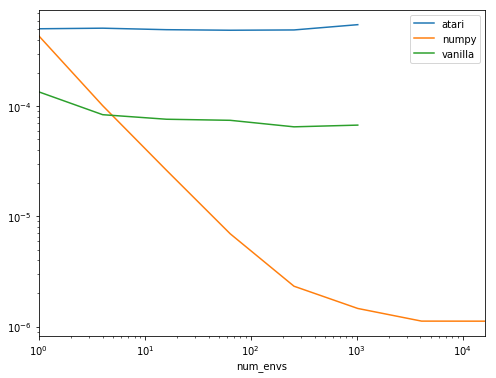

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
for name, group in dataframe.groupby('desc'):
    group.plot(x=1,y=1,ax=ax, logx=True, logy=True, label=name)